# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.


# Data Preparation

In [7]:
missing_mean = df.isna().mean()
display(missing_mean[missing_mean > 0.5])

stem-root            0.843931
stem-surface         0.624277
veil-type            0.947977
veil-color           0.878613
spore-print-color    0.895954
dtype: float64

In [8]:
df = df.drop(['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color'], axis=1)
df= df.dropna()

# Encoding and Splitting

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

X_train = np.concatenate((X_train_encoded, X_train_numerical), axis=1)
X_test = np.concatenate((X_test_encoded, X_test_numerical), axis=1)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'C': 100}
Best accuracy score: 0.9354168808747302
Test accuracy: 0.9366007194244604
Logistic Regression Validation Classification Report:
              precision    recall  f1-score   support

           e       0.95      0.91      0.93      1977
           p       0.93      0.96      0.94      2471

    accuracy                           0.94      4448
   macro avg       0.94      0.93      0.94      4448
weighted avg       0.94      0.94      0.94      4448



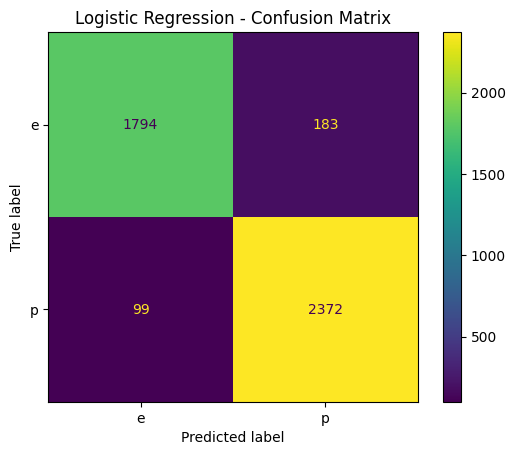

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

accuracy_scorer = make_scorer(accuracy_score)

lr = LogisticRegression(
    penalty='l2',      
    solver='lbfgs',    
    max_iter=1000,      
    random_state=42
)

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring=accuracy_scorer,  
    cv=5,                      
    n_jobs=-1,                
    verbose=1                
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

lr = grid_search.best_estimator_
y_pred = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

print("Logistic Regression Validation Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot as heatmap
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['e', 'p'])
disp_dt.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()


Training Accuracy: 0.8915743915462875
Test Accuracy: 0.8878147482014388
Best Decision Tree Depth: 3
Test Accuracy: 0.8878147482014388
Decision Tree Classification Report:
              precision    recall  f1-score   support

           e       0.90      0.84      0.87      1977
           p       0.88      0.92      0.90      2471

    accuracy                           0.89      4448
   macro avg       0.89      0.88      0.89      4448
weighted avg       0.89      0.89      0.89      4448



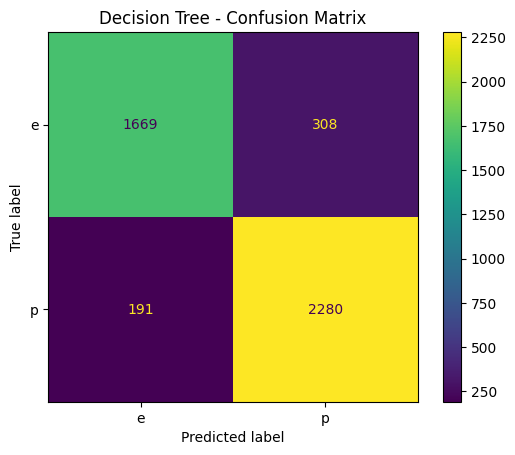

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Second model with different validation method (e.g. train/val split)
from sklearn.model_selection import train_test_split

# Split training into train/val (e.g., 80/20)
X_train_tree, X_val_tree, y_train_tree, y_val_tree = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Set up model and try different depths manually (simplest form of hyperparameter tuning)
best_score = 0
best_depth = None
best_tree = None
for depth in [3, 5, 10, None]:
    tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20)
    tree.fit(X_train_tree, y_train_tree)
    val_score = accuracy_score(y_val_tree, tree.predict(X_val_tree))
    if val_score > best_score:
        best_score = val_score
        best_depth = depth
        best_tree = tree

# Final model

tree_preds = best_tree.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, best_tree.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, tree_preds))
print("Best Decision Tree Depth:", best_depth)
print("Test Accuracy:", accuracy_score(y_test, tree_preds))
print("Decision Tree Classification Report:")
print(classification_report(y_test, tree_preds))

# Plot confusion matrix
cm_tree = confusion_matrix(y_test, tree_preds)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['e', 'p'])
disp_tree.plot()
plt.title("Decision Tree - Confusion Matrix")
plt.grid(False)
plt.show()
